# Codeword Length = 15, T = 10, p(BSC parameter) {0.01, 0.05, 0.1, 0.2}

In [3]:
# changepoint_detection_updated.py
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
print(os.listdir("/kaggle/input/bsc-0-01-15-seq-len"))

['bsc_p0.40_codewords1.csv', 'bsc_p0.20_codewords2.csv', 'bsc_p0.01_codewords1.csv', 'bsc_p0.05_codewords1.csv', 'bsc_p0.01_codewords2.csv', 'bsc_p0.30_codewords1.csv', 'bsc_p0.10_codewords1.csv', 'bsc_p0.20_codewords1.csv', 'bsc_p0.10_codewords2.csv', 'bsc_p0.30_codewords2.csv', 'bsc_p0.40_codewords2.csv', 'bsc_p0.05_codewords2.csv']


## p = 0.01

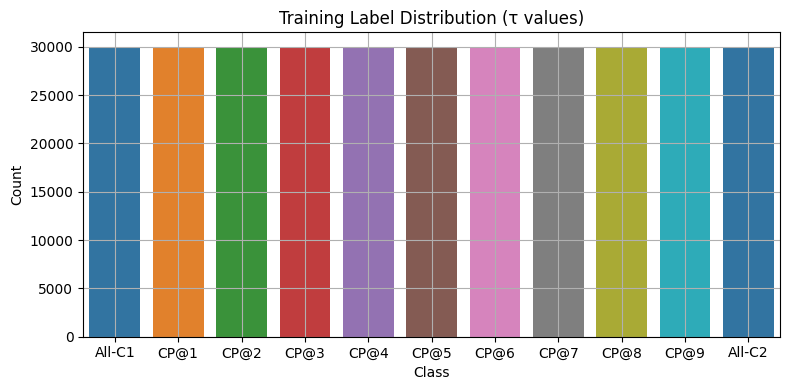

Training Epochs:   2%|▏         | 1/50 [00:27<22:21, 27.39s/it]

Epoch  1 | Train Loss: 2.3821 | Val Accuracy: 0.2272


Training Epochs:   4%|▍         | 2/50 [00:55<22:03, 27.58s/it]

Epoch  2 | Train Loss: 1.4141 | Val Accuracy: 0.6218


Training Epochs:   6%|▌         | 3/50 [01:22<21:37, 27.60s/it]

Epoch  3 | Train Loss: 1.0133 | Val Accuracy: 0.7541


Training Epochs:   8%|▊         | 4/50 [01:50<21:10, 27.62s/it]

Epoch  4 | Train Loss: 0.8037 | Val Accuracy: 0.8316


Training Epochs:  10%|█         | 5/50 [02:17<20:37, 27.49s/it]

Epoch  5 | Train Loss: 0.6316 | Val Accuracy: 0.8934


Training Epochs:  12%|█▏        | 6/50 [02:45<20:12, 27.55s/it]

Epoch  6 | Train Loss: 0.5038 | Val Accuracy: 0.9198


Training Epochs:  14%|█▍        | 7/50 [03:12<19:44, 27.54s/it]

Epoch  7 | Train Loss: 0.4187 | Val Accuracy: 0.9375


Training Epochs:  16%|█▌        | 8/50 [03:40<19:19, 27.62s/it]

Epoch  8 | Train Loss: 0.3589 | Val Accuracy: 0.9486


Training Epochs:  18%|█▊        | 9/50 [04:08<18:49, 27.55s/it]

Epoch  9 | Train Loss: 0.3146 | Val Accuracy: 0.9557


Training Epochs:  20%|██        | 10/50 [04:35<18:22, 27.56s/it]

Epoch 10 | Train Loss: 0.2822 | Val Accuracy: 0.9609


Training Epochs:  22%|██▏       | 11/50 [05:02<17:51, 27.48s/it]

Epoch 11 | Train Loss: 0.2593 | Val Accuracy: 0.9635


Training Epochs:  24%|██▍       | 12/50 [05:30<17:24, 27.48s/it]

Epoch 12 | Train Loss: 0.2451 | Val Accuracy: 0.9651


Training Epochs:  26%|██▌       | 13/50 [05:57<16:54, 27.43s/it]

Epoch 13 | Train Loss: 0.2299 | Val Accuracy: 0.9660


Training Epochs:  28%|██▊       | 14/50 [06:25<16:29, 27.48s/it]

Epoch 14 | Train Loss: 0.2195 | Val Accuracy: 0.9682


Training Epochs:  30%|███       | 15/50 [06:52<16:01, 27.47s/it]

Epoch 15 | Train Loss: 0.2119 | Val Accuracy: 0.9685


Training Epochs:  32%|███▏      | 16/50 [07:20<15:34, 27.49s/it]

Epoch 16 | Train Loss: 0.2047 | Val Accuracy: 0.9685


Training Epochs:  34%|███▍      | 17/50 [07:47<15:08, 27.53s/it]

Epoch 17 | Train Loss: 0.1996 | Val Accuracy: 0.9692


Training Epochs:  34%|███▍      | 17/50 [08:15<16:01, 29.15s/it]

Epoch 18 | Train Loss: 0.1957 | Val Accuracy: 0.9688
Early stopping triggered.



Final Test Accuracy: 0.9685



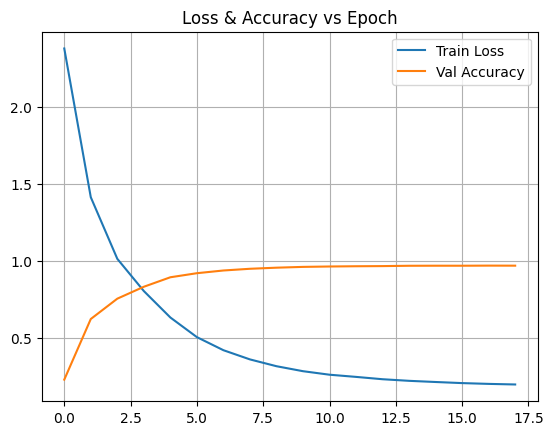

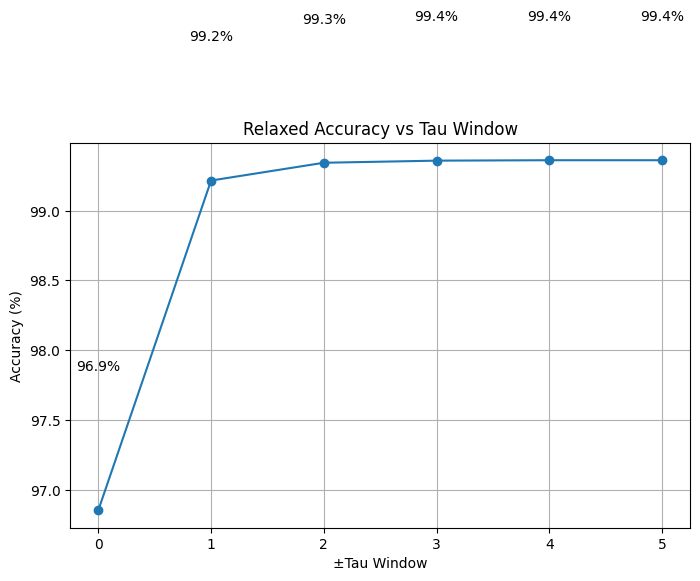

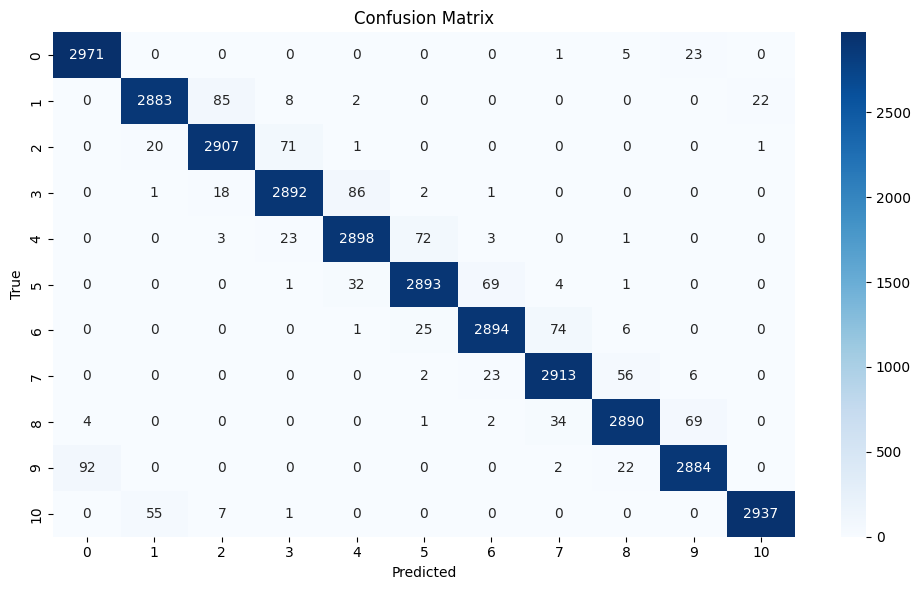

In [13]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 30000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.01, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 10.6, 26.5, 41.4, 54.9, 64.9, 76.7
For N'(training samples/class) = 2000     Accuracy = 9.2 
For N'(training samples/class) = 3000     Accuracy = 9.4, 27.4, 43.4, 56.0, 68.8, 78.1
For N'(training samples/class) = 4000     Accuracy = 87.3, 95.8, 96.6, 96.8, 96.8, 96.9
For N'(training samples/class) = 5000     Accuracy = 92.2, 98.1, 98.5, 98.6, 98.6, 98.6
For N'(training samples/class) = 6000     Accuracy = 92.6
For N'(training samples/class) = 8000     Accuracy = 93.5
For N'(training samples/class) = 10000     Accuracy = 95.9, 96.8, 99.0, 99.0, 99.0, 99.0
For N'(training samples/class) = 11000     Accuracy = 96.4
For N'(training samples/class) = 12000     Accuracy = 96.2
For N'(training samples/class) = 15000     Accuracy = 96.1, 98.9, 99.1, 99.1, 99.1, 99.1
For N'(training samples/class) = 30000     Accuracy = 96.9
For N'(training samples/class) = 45000     Accuracy = 97.1
</pre>

## p = 0.05

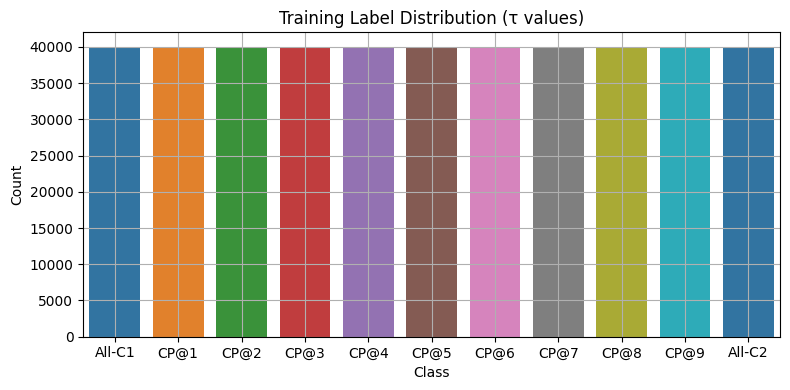

Training Epochs:   2%|▏         | 1/50 [00:36<29:50, 36.53s/it]

Epoch  1 | Train Loss: 2.3985 | Val Accuracy: 0.1167


Training Epochs:   4%|▍         | 2/50 [01:13<29:19, 36.65s/it]

Epoch  2 | Train Loss: 1.7596 | Val Accuracy: 0.4472


Training Epochs:   6%|▌         | 3/50 [01:50<28:47, 36.76s/it]

Epoch  3 | Train Loss: 1.3432 | Val Accuracy: 0.5720


Training Epochs:   8%|▊         | 4/50 [02:26<28:08, 36.70s/it]

Epoch  4 | Train Loss: 1.1504 | Val Accuracy: 0.6765


Training Epochs:  10%|█         | 5/50 [03:03<27:35, 36.79s/it]

Epoch  5 | Train Loss: 1.0086 | Val Accuracy: 0.7411


Training Epochs:  12%|█▏        | 6/50 [03:40<26:56, 36.74s/it]

Epoch  6 | Train Loss: 0.9009 | Val Accuracy: 0.7788


Training Epochs:  14%|█▍        | 7/50 [04:16<26:15, 36.64s/it]

Epoch  7 | Train Loss: 0.8202 | Val Accuracy: 0.8005


Training Epochs:  16%|█▌        | 8/50 [04:53<25:41, 36.69s/it]

Epoch  8 | Train Loss: 0.7600 | Val Accuracy: 0.8129


Training Epochs:  18%|█▊        | 9/50 [05:30<25:04, 36.70s/it]

Epoch  9 | Train Loss: 0.7169 | Val Accuracy: 0.8242


Training Epochs:  20%|██        | 10/50 [06:06<24:25, 36.65s/it]

Epoch 10 | Train Loss: 0.6827 | Val Accuracy: 0.8338


Training Epochs:  22%|██▏       | 11/50 [06:43<23:46, 36.58s/it]

Epoch 11 | Train Loss: 0.6559 | Val Accuracy: 0.8380


Training Epochs:  24%|██▍       | 12/50 [07:20<23:11, 36.62s/it]

Epoch 12 | Train Loss: 0.6320 | Val Accuracy: 0.8445


Training Epochs:  26%|██▌       | 13/50 [07:56<22:33, 36.59s/it]

Epoch 13 | Train Loss: 0.6126 | Val Accuracy: 0.8480


Training Epochs:  28%|██▊       | 14/50 [08:33<21:58, 36.61s/it]

Epoch 14 | Train Loss: 0.5963 | Val Accuracy: 0.8529


Training Epochs:  30%|███       | 15/50 [09:10<21:24, 36.71s/it]

Epoch 15 | Train Loss: 0.5850 | Val Accuracy: 0.8546


Training Epochs:  32%|███▏      | 16/50 [09:46<20:47, 36.70s/it]

Epoch 16 | Train Loss: 0.5708 | Val Accuracy: 0.8578


Training Epochs:  34%|███▍      | 17/50 [10:23<20:11, 36.71s/it]

Epoch 17 | Train Loss: 0.5619 | Val Accuracy: 0.8595


Training Epochs:  36%|███▌      | 18/50 [11:00<19:33, 36.67s/it]

Epoch 18 | Train Loss: 0.5521 | Val Accuracy: 0.8620


Training Epochs:  38%|███▊      | 19/50 [11:36<18:56, 36.67s/it]

Epoch 19 | Train Loss: 0.5431 | Val Accuracy: 0.8628


Training Epochs:  40%|████      | 20/50 [12:13<18:20, 36.67s/it]

Epoch 20 | Train Loss: 0.5340 | Val Accuracy: 0.8630


Training Epochs:  42%|████▏     | 21/50 [12:50<17:43, 36.68s/it]

Epoch 21 | Train Loss: 0.5294 | Val Accuracy: 0.8650


Training Epochs:  44%|████▍     | 22/50 [13:26<17:08, 36.72s/it]

Epoch 22 | Train Loss: 0.5220 | Val Accuracy: 0.8653


Training Epochs:  46%|████▌     | 23/50 [14:03<16:28, 36.62s/it]

Epoch 23 | Train Loss: 0.5136 | Val Accuracy: 0.8664


Training Epochs:  48%|████▊     | 24/50 [14:39<15:50, 36.56s/it]

Epoch 24 | Train Loss: 0.5082 | Val Accuracy: 0.8683


Training Epochs:  50%|█████     | 25/50 [15:16<15:13, 36.54s/it]

Epoch 25 | Train Loss: 0.5013 | Val Accuracy: 0.8699


Training Epochs:  52%|█████▏    | 26/50 [15:52<14:37, 36.58s/it]

Epoch 26 | Train Loss: 0.4962 | Val Accuracy: 0.8685


Training Epochs:  54%|█████▍    | 27/50 [16:29<14:02, 36.64s/it]

Epoch 27 | Train Loss: 0.4890 | Val Accuracy: 0.8692


Training Epochs:  56%|█████▌    | 28/50 [17:06<13:26, 36.66s/it]

Epoch 28 | Train Loss: 0.4840 | Val Accuracy: 0.8713


Training Epochs:  58%|█████▊    | 29/50 [17:42<12:48, 36.61s/it]

Epoch 29 | Train Loss: 0.4787 | Val Accuracy: 0.8717


Training Epochs:  60%|██████    | 30/50 [18:19<12:12, 36.63s/it]

Epoch 30 | Train Loss: 0.4764 | Val Accuracy: 0.8706


Training Epochs:  62%|██████▏   | 31/50 [18:56<11:36, 36.63s/it]

Epoch 31 | Train Loss: 0.4713 | Val Accuracy: 0.8693


Training Epochs:  62%|██████▏   | 31/50 [19:32<11:58, 37.84s/it]

Epoch 32 | Train Loss: 0.4677 | Val Accuracy: 0.8724
Early stopping triggered.



Final Test Accuracy: 0.8785



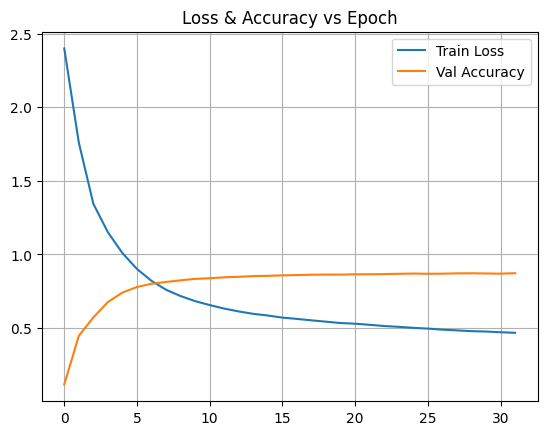

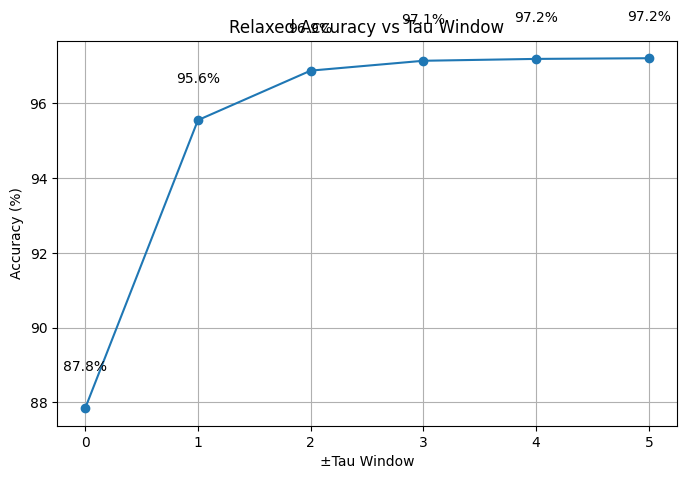

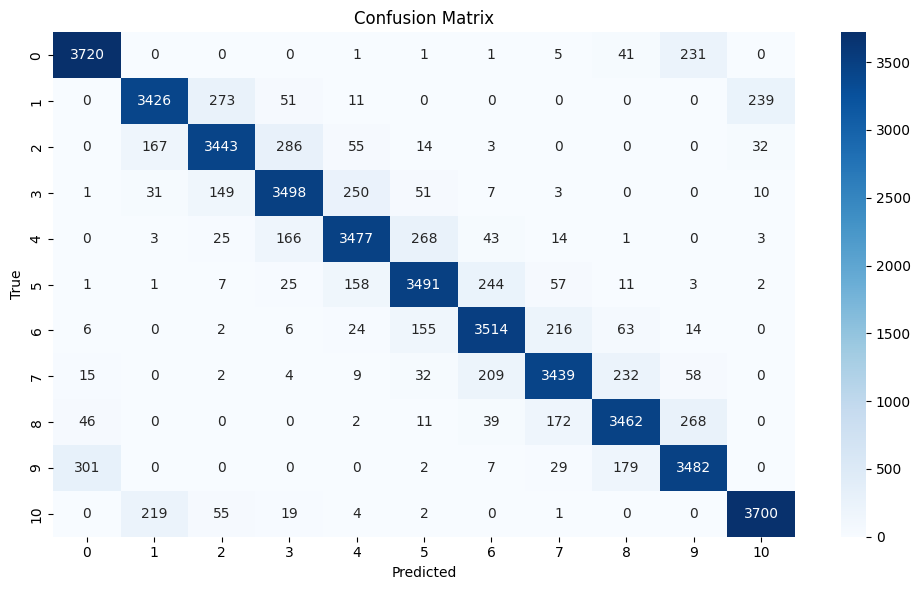

In [17]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 40000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.05, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 8.6, 25.2, 38.5, 50.5, 61.6, 73.7
For N'(training samples/class) = 2000     Accuracy = 10.0, 25.4, 40.9, 52.1, 62.0, 70.1
For N'(training samples/class) = 3000     Accuracy = 54.8, 83.4, 88.5
For N'(training samples/class) = 4000     Accuracy = 64.9, 87.9
For N'(training samples/class) = 5000     Accuracy = 71.9, 91.4, 93.6, 94.0, 94.2, 94.2
For N'(training samples/class) = 6000     Accuracy = 76.5
For N'(training samples/class) = 8000     Accuracy = 79.4
For N'(training samples/class) = 10000     Accuracy = 83.1, 94.2, 95.7, 96.1, 96.2, 96.3
For N'(training samples/class) = 11000     Accuracy = 83.3
For N'(training samples/class) = 12000     Accuracy = 82.9
For N'(training samples/class) = 15000     Accuracy = 83.43, 93.6, 95.2, 95.7, 95.8, 95.9
For N'(training samples/class) = 20000     Accuracy = 85.7, 94.8, 96.2, 96.5, 96.7, 96.7
For N'(training samples/class) = 25000     Accuracy = 86.1
For N'(training samples/class) = 30000     Accuracy = 87.2, 95.2, 96.6, 96.9, 97.0, 97.0
For N'(training samples/class) = 40000     Accuracy = 87.8
For N'(training samples/class) = 50000     Accuracy = 87.7
</pre>

## p = 0.1

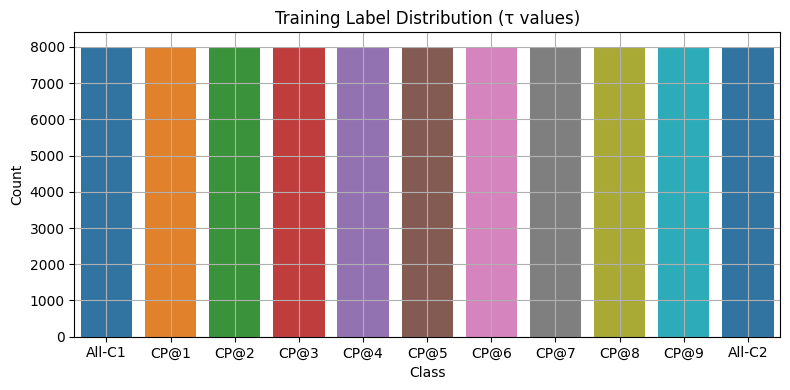

Training Epochs:   2%|▏         | 1/50 [00:07<06:02,  7.39s/it]

Epoch  1 | Train Loss: 2.4027 | Val Accuracy: 0.0886


Training Epochs:   4%|▍         | 2/50 [00:14<05:52,  7.35s/it]

Epoch  2 | Train Loss: 2.3981 | Val Accuracy: 0.0941


Training Epochs:   6%|▌         | 3/50 [00:21<05:43,  7.31s/it]

Epoch  3 | Train Loss: 2.3971 | Val Accuracy: 0.0957


Training Epochs:   8%|▊         | 4/50 [00:29<05:34,  7.28s/it]

Epoch  4 | Train Loss: 2.3959 | Val Accuracy: 0.0960


Training Epochs:  10%|█         | 5/50 [00:36<05:28,  7.29s/it]

Epoch  5 | Train Loss: 2.3946 | Val Accuracy: 0.0972


Training Epochs:  12%|█▏        | 6/50 [00:44<05:24,  7.37s/it]

Epoch  6 | Train Loss: 2.3917 | Val Accuracy: 0.0917


Training Epochs:  14%|█▍        | 7/50 [00:51<05:15,  7.33s/it]

Epoch  7 | Train Loss: 2.3882 | Val Accuracy: 0.0972


Training Epochs:  16%|█▌        | 8/50 [00:58<05:07,  7.32s/it]

Epoch  8 | Train Loss: 2.3789 | Val Accuracy: 0.1094


Training Epochs:  18%|█▊        | 9/50 [01:05<04:59,  7.30s/it]

Epoch  9 | Train Loss: 2.3316 | Val Accuracy: 0.1497


Training Epochs:  20%|██        | 10/50 [01:13<04:53,  7.33s/it]

Epoch 10 | Train Loss: 2.2226 | Val Accuracy: 0.1836


Training Epochs:  22%|██▏       | 11/50 [01:20<04:45,  7.33s/it]

Epoch 11 | Train Loss: 2.1147 | Val Accuracy: 0.2210


Training Epochs:  24%|██▍       | 12/50 [01:27<04:38,  7.33s/it]

Epoch 12 | Train Loss: 2.0062 | Val Accuracy: 0.2648


Training Epochs:  26%|██▌       | 13/50 [01:35<04:32,  7.35s/it]

Epoch 13 | Train Loss: 1.9071 | Val Accuracy: 0.2935


Training Epochs:  28%|██▊       | 14/50 [01:42<04:24,  7.36s/it]

Epoch 14 | Train Loss: 1.8403 | Val Accuracy: 0.3015


Training Epochs:  30%|███       | 15/50 [01:50<04:17,  7.36s/it]

Epoch 15 | Train Loss: 1.7800 | Val Accuracy: 0.3216


Training Epochs:  32%|███▏      | 16/50 [01:57<04:09,  7.34s/it]

Epoch 16 | Train Loss: 1.7331 | Val Accuracy: 0.3314


Training Epochs:  34%|███▍      | 17/50 [02:04<04:02,  7.36s/it]

Epoch 17 | Train Loss: 1.6930 | Val Accuracy: 0.3486


Training Epochs:  36%|███▌      | 18/50 [02:12<03:55,  7.37s/it]

Epoch 18 | Train Loss: 1.6571 | Val Accuracy: 0.3549


Training Epochs:  38%|███▊      | 19/50 [02:19<03:48,  7.37s/it]

Epoch 19 | Train Loss: 1.6276 | Val Accuracy: 0.3698


Training Epochs:  40%|████      | 20/50 [02:26<03:41,  7.38s/it]

Epoch 20 | Train Loss: 1.5982 | Val Accuracy: 0.3783


Training Epochs:  42%|████▏     | 21/50 [02:34<03:33,  7.35s/it]

Epoch 21 | Train Loss: 1.5732 | Val Accuracy: 0.3786


Training Epochs:  44%|████▍     | 22/50 [02:41<03:25,  7.32s/it]

Epoch 22 | Train Loss: 1.5482 | Val Accuracy: 0.3892


Training Epochs:  46%|████▌     | 23/50 [02:48<03:19,  7.38s/it]

Epoch 23 | Train Loss: 1.5271 | Val Accuracy: 0.3868


Training Epochs:  48%|████▊     | 24/50 [02:56<03:11,  7.37s/it]

Epoch 24 | Train Loss: 1.5041 | Val Accuracy: 0.4009


Training Epochs:  50%|█████     | 25/50 [03:03<03:04,  7.36s/it]

Epoch 25 | Train Loss: 1.4807 | Val Accuracy: 0.4083


Training Epochs:  52%|█████▏    | 26/50 [03:10<02:56,  7.35s/it]

Epoch 26 | Train Loss: 1.4655 | Val Accuracy: 0.4158


Training Epochs:  54%|█████▍    | 27/50 [03:18<02:50,  7.39s/it]

Epoch 27 | Train Loss: 1.4446 | Val Accuracy: 0.4228


Training Epochs:  56%|█████▌    | 28/50 [03:25<02:41,  7.34s/it]

Epoch 28 | Train Loss: 1.4274 | Val Accuracy: 0.4268


Training Epochs:  58%|█████▊    | 29/50 [03:33<02:33,  7.33s/it]

Epoch 29 | Train Loss: 1.4095 | Val Accuracy: 0.4342


Training Epochs:  60%|██████    | 30/50 [03:40<02:26,  7.32s/it]

Epoch 30 | Train Loss: 1.3966 | Val Accuracy: 0.4376


Training Epochs:  62%|██████▏   | 31/50 [03:47<02:19,  7.35s/it]

Epoch 31 | Train Loss: 1.3811 | Val Accuracy: 0.4477


Training Epochs:  64%|██████▍   | 32/50 [03:55<02:12,  7.35s/it]

Epoch 32 | Train Loss: 1.3664 | Val Accuracy: 0.4535


Training Epochs:  66%|██████▌   | 33/50 [04:02<02:04,  7.34s/it]

Epoch 33 | Train Loss: 1.3500 | Val Accuracy: 0.4539


Training Epochs:  68%|██████▊   | 34/50 [04:09<01:57,  7.33s/it]

Epoch 34 | Train Loss: 1.3386 | Val Accuracy: 0.4652


Training Epochs:  70%|███████   | 35/50 [04:17<01:49,  7.33s/it]

Epoch 35 | Train Loss: 1.3249 | Val Accuracy: 0.4669


Training Epochs:  72%|███████▏  | 36/50 [04:24<01:43,  7.38s/it]

Epoch 36 | Train Loss: 1.3128 | Val Accuracy: 0.4715


Training Epochs:  74%|███████▍  | 37/50 [04:31<01:35,  7.36s/it]

Epoch 37 | Train Loss: 1.3034 | Val Accuracy: 0.4749


Training Epochs:  76%|███████▌  | 38/50 [04:39<01:28,  7.36s/it]

Epoch 38 | Train Loss: 1.2887 | Val Accuracy: 0.4791


Training Epochs:  78%|███████▊  | 39/50 [04:46<01:20,  7.34s/it]

Epoch 39 | Train Loss: 1.2804 | Val Accuracy: 0.4855


Training Epochs:  80%|████████  | 40/50 [04:54<01:13,  7.40s/it]

Epoch 40 | Train Loss: 1.2687 | Val Accuracy: 0.4865


Training Epochs:  82%|████████▏ | 41/50 [05:01<01:06,  7.38s/it]

Epoch 41 | Train Loss: 1.2584 | Val Accuracy: 0.4933


Training Epochs:  84%|████████▍ | 42/50 [05:08<00:58,  7.34s/it]

Epoch 42 | Train Loss: 1.2497 | Val Accuracy: 0.4955


Training Epochs:  86%|████████▌ | 43/50 [05:15<00:51,  7.34s/it]

Epoch 43 | Train Loss: 1.2389 | Val Accuracy: 0.4989


Training Epochs:  88%|████████▊ | 44/50 [05:23<00:43,  7.33s/it]

Epoch 44 | Train Loss: 1.2284 | Val Accuracy: 0.5059


Training Epochs:  90%|█████████ | 45/50 [05:30<00:36,  7.35s/it]

Epoch 45 | Train Loss: 1.2168 | Val Accuracy: 0.5075


Training Epochs:  92%|█████████▏| 46/50 [05:37<00:29,  7.31s/it]

Epoch 46 | Train Loss: 1.2131 | Val Accuracy: 0.5135


Training Epochs:  94%|█████████▍| 47/50 [05:45<00:21,  7.30s/it]

Epoch 47 | Train Loss: 1.2045 | Val Accuracy: 0.5108


Training Epochs:  96%|█████████▌| 48/50 [05:52<00:14,  7.35s/it]

Epoch 48 | Train Loss: 1.1916 | Val Accuracy: 0.5167


Training Epochs:  98%|█████████▊| 49/50 [05:59<00:07,  7.36s/it]

Epoch 49 | Train Loss: 1.1876 | Val Accuracy: 0.5235


Training Epochs: 100%|██████████| 50/50 [06:07<00:00,  7.34s/it]

Epoch 50 | Train Loss: 1.1754 | Val Accuracy: 0.5239



Final Test Accuracy: 0.5316



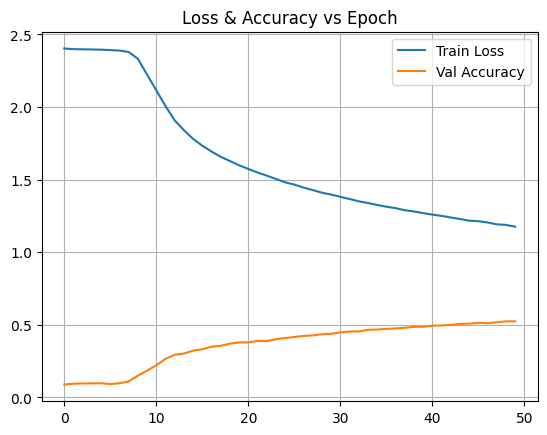

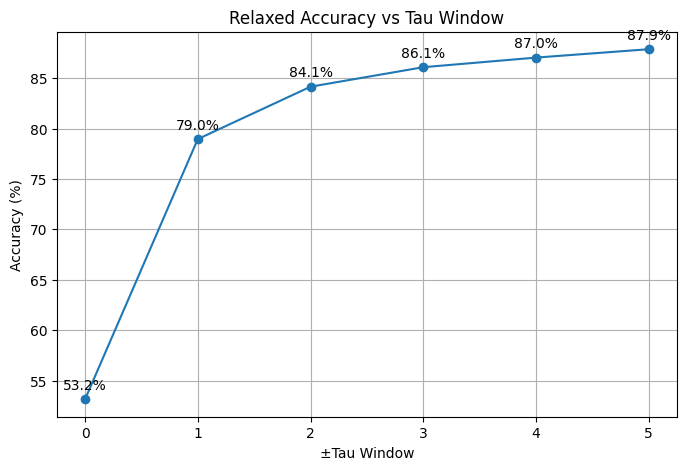

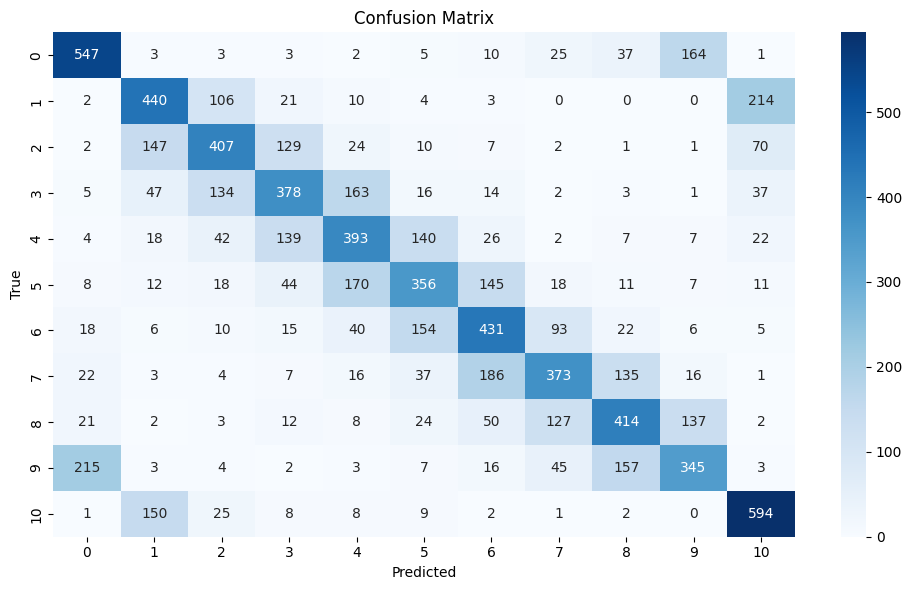

In [10]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 8000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.10, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br> 
<pre> 
For N'(training samples/class) = 1000     Accuracy = 8.7, 26.5, 42.5, 54.7, 69.4, 81.0
For N'(training samples/class) = 2000     Accuracy = 8.8
For N'(training samples/class) = 3000     Accuracy = 9.1
For N'(training samples/class) = 4000     Accuracy = 9.6, 27.6, 43.8, 56.1, 67.7, 78.1, 
For N'(training samples/class) = 5000     Accuracy = 9.3
For N'(training samples/class) = 6000     Accuracy = 9.1
For N'(training samples/class) = 7000     Accuracy = 22.6
For N'(training samples/class) = 8000     Accuracy = 53.2
For N'(training samples/class) = 10000     Accuracy = 57.8, 81.5, 86.4, 88.1, 89.0, 89.6
For N'(training samples/class) = 11000     Accuracy = 57.9
For N'(training samples/class) = 12000     Accuracy = 59.1
For N'(training samples/class) = 15000     Accuracy = 62.5
For N'(training samples/class) = 20000     Accuracy = 64.6
For N'(training samples/class) = 30000     Accuracy = 66.5, 82.8, 87.8, 89.8, 90.6, 91.1
For N'(training samples/class) = 60000     Accuracy = 69.0, 84.5, 89.5, 91.3, 92.1, 92.5
For N'(training samples/class) = 70000     Accuracy = 69.5 
For N'(training samples/class) = 80000     Accuracy = 70.1
</pre>

## p = 0.2

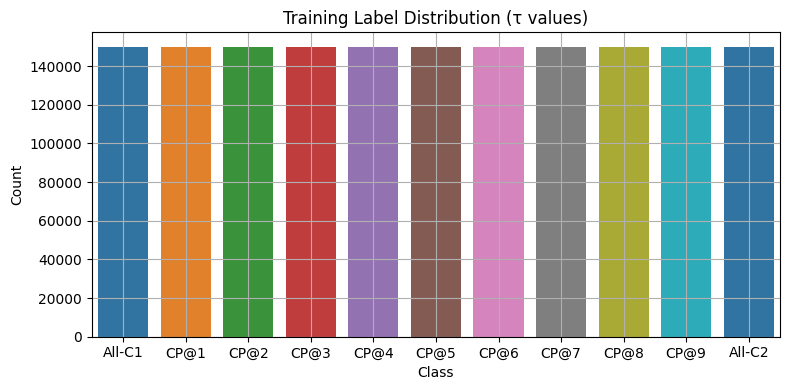

Training Epochs:   2%|▏         | 1/50 [02:20<1:54:56, 140.75s/it]

Epoch  1 | Train Loss: 2.3984 | Val Accuracy: 0.0909


Training Epochs:   4%|▍         | 2/50 [04:41<1:52:47, 141.00s/it]

Epoch  2 | Train Loss: 2.3979 | Val Accuracy: 0.0909


Training Epochs:   6%|▌         | 3/50 [07:03<1:50:38, 141.25s/it]

Epoch  3 | Train Loss: 2.3979 | Val Accuracy: 0.0909


Training Epochs:   8%|▊         | 4/50 [09:24<1:48:14, 141.18s/it]

Epoch  4 | Train Loss: 2.3979 | Val Accuracy: 0.0909


Training Epochs:   8%|▊         | 4/50 [11:45<2:15:15, 176.43s/it]

Epoch  5 | Train Loss: 2.3979 | Val Accuracy: 0.0909
Early stopping triggered.



Final Test Accuracy: 0.0909



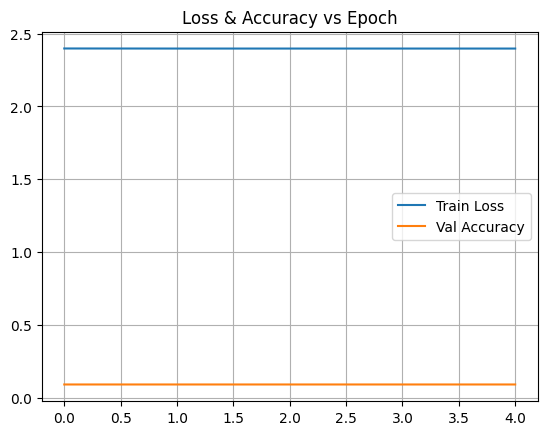

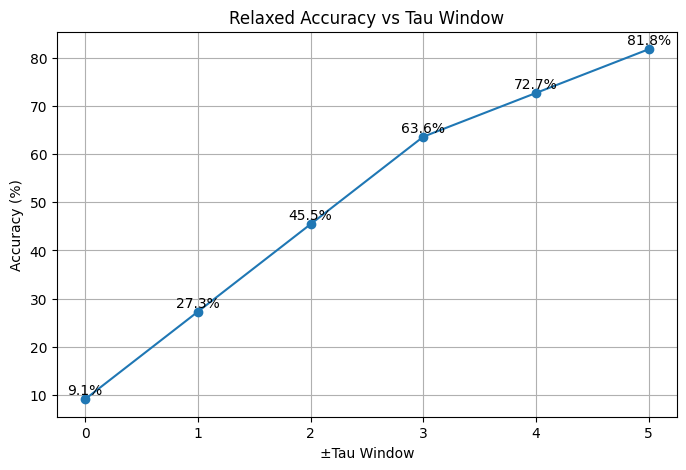

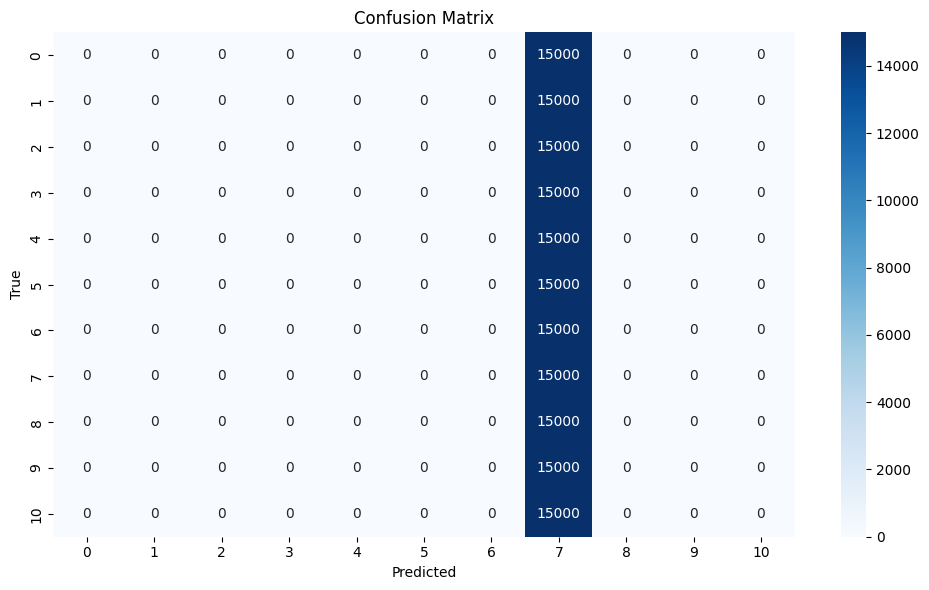

In [9]:
# ========== Configuration ==========
SEED = 0
T = 10
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 150000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.20_codewords1.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.20_codewords2.csv").values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
# X, y = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN + SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=SAMPLES_PER_CLASS_TEST * NUM_CLASSES, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval)
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST, csv1, csv2, T)



# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ChangepointDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(ChangepointDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = 0
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


***T = 10, p = 0.20, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 9.7, 28.7, 44.4, 57.9, 69.5, 79.9
For N'(training samples/class) = 2000     Accuracy = 9.1
For N'(training samples/class) = 3000     Accuracy = 8.5
For N'(training samples/class) = 4000     Accuracy = 8.8
For N'(training samples/class) = 5000     Accuracy = 9.1, 26.5, 42.6, 56.2, 68.6, 79.9
For N'(training samples/class) = 6000     Accuracy = 9.4
For N'(training samples/class) = 8000     Accuracy = 9.2
For N'(training samples/class) = 10000     Accuracy = 9.3, 26.8, 41.9, 55.5, 66.1, 76.0
For N'(training samples/class) = 11000     Accuracy = 9.0
For N'(training samples/class) = 12000     Accuracy = 9.2
For N'(training samples/class) = 15000     Accuracy = 8.9
For N'(training samples/class) = 20000     Accuracy = 9.1, 26.0, 40.9, 54.2, 65.8, 75.7
For N'(training samples/class) = 40000     Accuracy = 9.2, 26.9, 41.2, 52,5, 62.8, 72.3
For N'(training samples/class) = 100000    Accuracy = 23.5, 45.4, 57.0, 64.3, 69.7, 74.2
For N'(training samples/class) = 120000    Accuracy = 23.6
    
</pre>